# Score OCR Results

## Setup

In [1]:
import sys

sys.path.append('..')

In [23]:
import json
import random
import shutil
from os.path import word_split, splitext
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from PIL import Image

import digi_leap.pylib.ocr_results as results

In [3]:
ROOT_DIR = Path('..')

JUNK_DIR = ROOT_DIR / 'junk'
OUTPUT_DIR = ROOT_DIR / 'output'
TEXT_DIR = OUTPUT_DIR / 'ensemble_faster_rcnn_2021-08-18_text'
IMAGE_DIR = OUTPUT_DIR / 'ensemble_faster_rcnn_2021-08-18_images'

RECONCILED_JSON = OUTPUT_DIR / '17633_label_babel_2.reconciled.jsonl'

## Reconciled Data

In [4]:
with open(RECONCILED_JSON) as lines:
    RECONCILED = [json.loads(ln) for ln in lines.readlines()]

## OCR Text Files

In [5]:
ALL_FILES = [str(f) for f in TEXT_DIR.glob('*.txt')]

SCORE_FILES = [f for f in ALL_FILES if f.find('Barcode') < 0]

TYPE_FILES = [f for f in ALL_FILES if f.find('Typewritten') >= 0]
HAND_FILES = [f for f in ALL_FILES if f.find('Handwritten') >= 0]
BOTH_FILES = [f for f in ALL_FILES if f.find('Both') >= 0]
BARCODE_FILES = [f for f in ALL_FILES if f.find('Barcode') >= 0]

## Show Predicted Labels vs Reconciled Labels

The reconciled labels are what we're using as ground truth.

The predicted labels are what the model predicted

In [6]:
x, y = [], []

for rec in tqdm.tqdm(RECONCILED):
    y.append(len(rec['merged_types']))

    name, ext = splitext(rec['image_file'])
    pattern = '/' + name + '_'
    x.append(sum(1 for f in ALL_FILES if f.find(pattern) >= 0))

sum(x)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4994/4994 [00:27<00:00, 182.00it/s]


31759

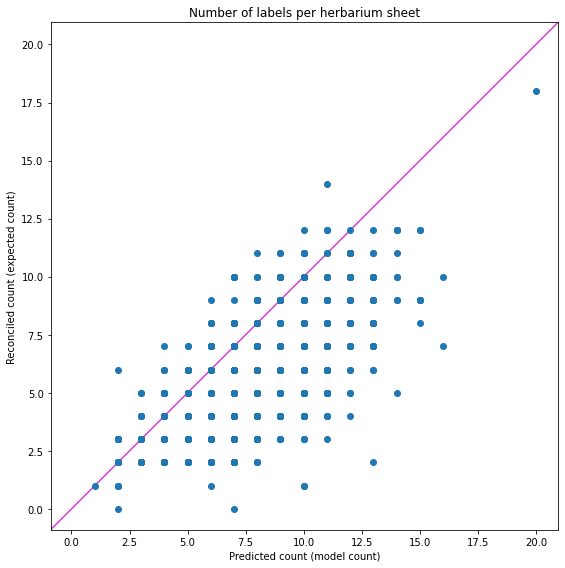

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x, y)

ax.set_xlabel('Predicted count (model count)')
ax.set_ylabel('Reconciled count (expected count)')
ax.set_title('Number of labels per herbarium sheet')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'm-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

fig.tight_layout()

fig.savefig(JUNK_DIR / 'labels_per_sheet.png', facecolor='white')
plt.show()

**This shows that the model predicts more labels than expected.**

There are several sources of the excess:
- The model regularly predicts rulers as a label.
- Occasionally the model will predict color guides as labels.
- The model is predicting small bits of text as a label. I haven't determined if the model is finding random bits of text or if it's breaking labels apart.

### This will affect all further results.

## Score a File

This function looks for word "hits" in the text file and divides that by the count of all "words" in the. A word is just any string of characters separated by white space.

A "hit" can be one of 3 things:
1. A match in the vocabulary. The vocabulary contains:
    1. The NLTK word corpus
    1. Taxon names for the plant kingdom scraped from the ITIS database
1. A number, which is a string of digits with commas or decimal points like `1,234.5`.
1. A date like `1/23/21` or `1-23-21`.

In [8]:
def score_file(path):
    with open(path) as text_file:
        text = text_file.read()
        words = text.word_split()
        count = len(words)

    if count == 0:
        return 0.0, 0

    hits = results.hits(text)
    return round(100.0 * hits / count), count

## Show All non-Barcode Scores

In [9]:
x = [score_file(p)[0] for p in SCORE_FILES]

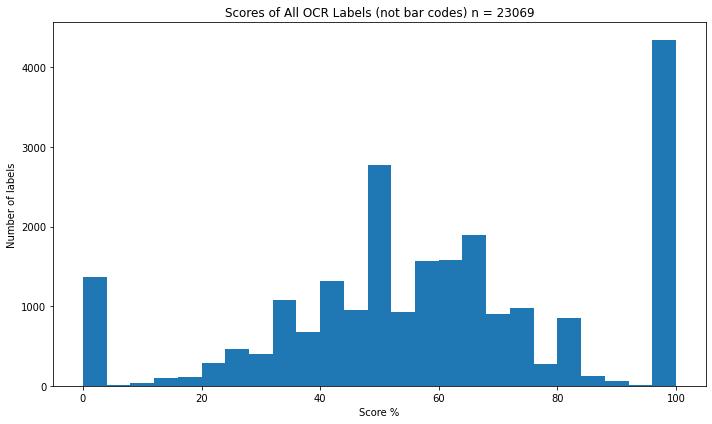

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of All OCR Labels (not bar codes) n = {len(x)}')
fig.tight_layout()

fig.savefig(JUNK_DIR / 'ocr_quality_all.png', facecolor='white')
plt.show()

## Show Typewritten Scores

In [11]:
x = [score_file(p)[0] for p in TYPE_FILES]

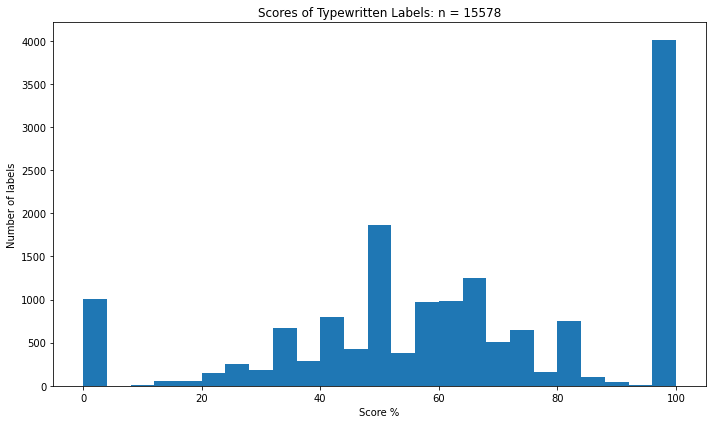

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Typewritten Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_typewritten.png', facecolor='white')
plt.show()

## Show Mixed (Typewritten & Handwritten) Scores

In [13]:
x = [score_file(p)[0] for p in BOTH_FILES]

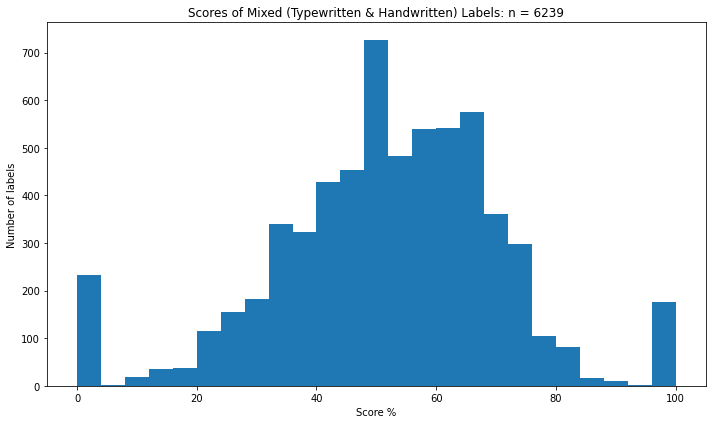

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Mixed (Typewritten & Handwritten) Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_mixed.png', facecolor='white')
plt.show()

## Show Handwritten Scores

In [15]:
x = [score_file(p)[0] for p in HAND_FILES]

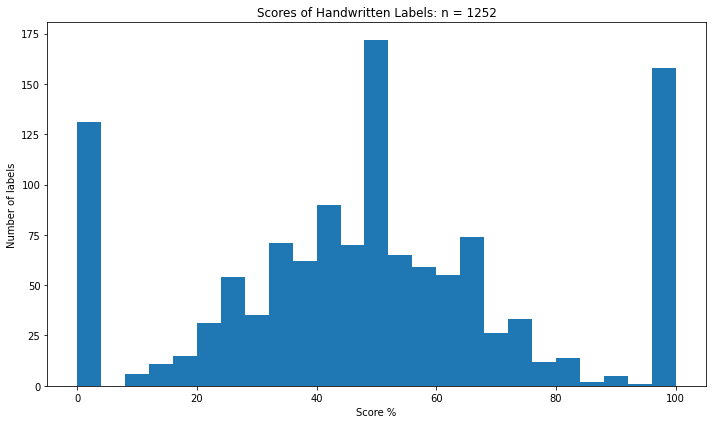

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Handwritten Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_handwritten.png', facecolor='white')
plt.show()

## Show Bar Code Scores

Many bar codes will have typewritten text on them.

In [17]:
x = [score_file(p)[0] for p in BARCODE_FILES]

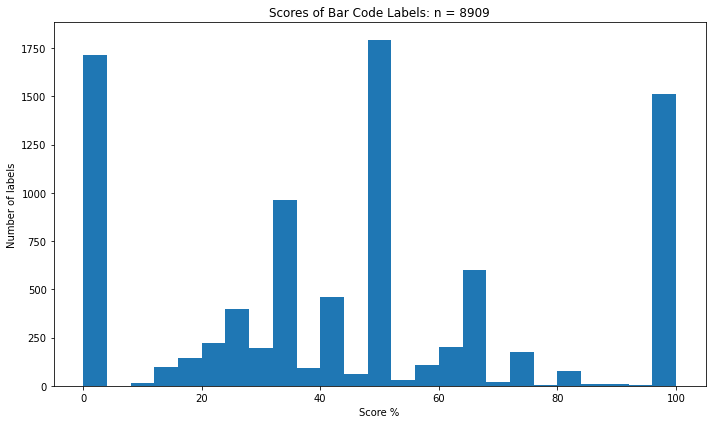

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Bar Code Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_barcode.png', facecolor='white')
plt.show()

## Sample Results

In [34]:
labels = random.sample(TYPE_FILES, 100)

In [35]:
images = []

for text in labels:
    name = Path(text).stem
    src = IMAGE_DIR / f'{name}.jpg'
    images.append(src)
    # dst = JUNK_DIR / f'{name}.jpg'
    # shutil.copyfile(src, dst)

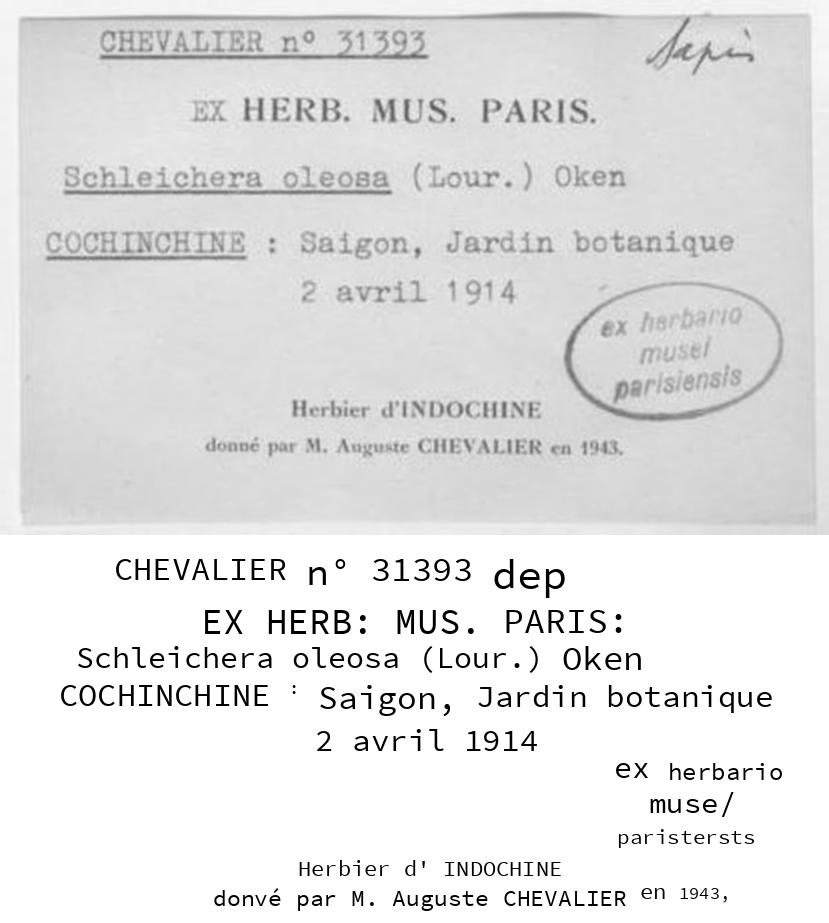

In [36]:
image = Image.open(images[0])
display(image)

The OCR engine seems to be transcribing non-English characters.

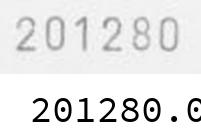

In [40]:
image = Image.open(images[10])
display(image)

This is one of the small non-labels I mentioned above.

Note that the Python library, Pandas, is "helpfully" adding the ".0". This is a common problem with the small labels that I'll have to fix.

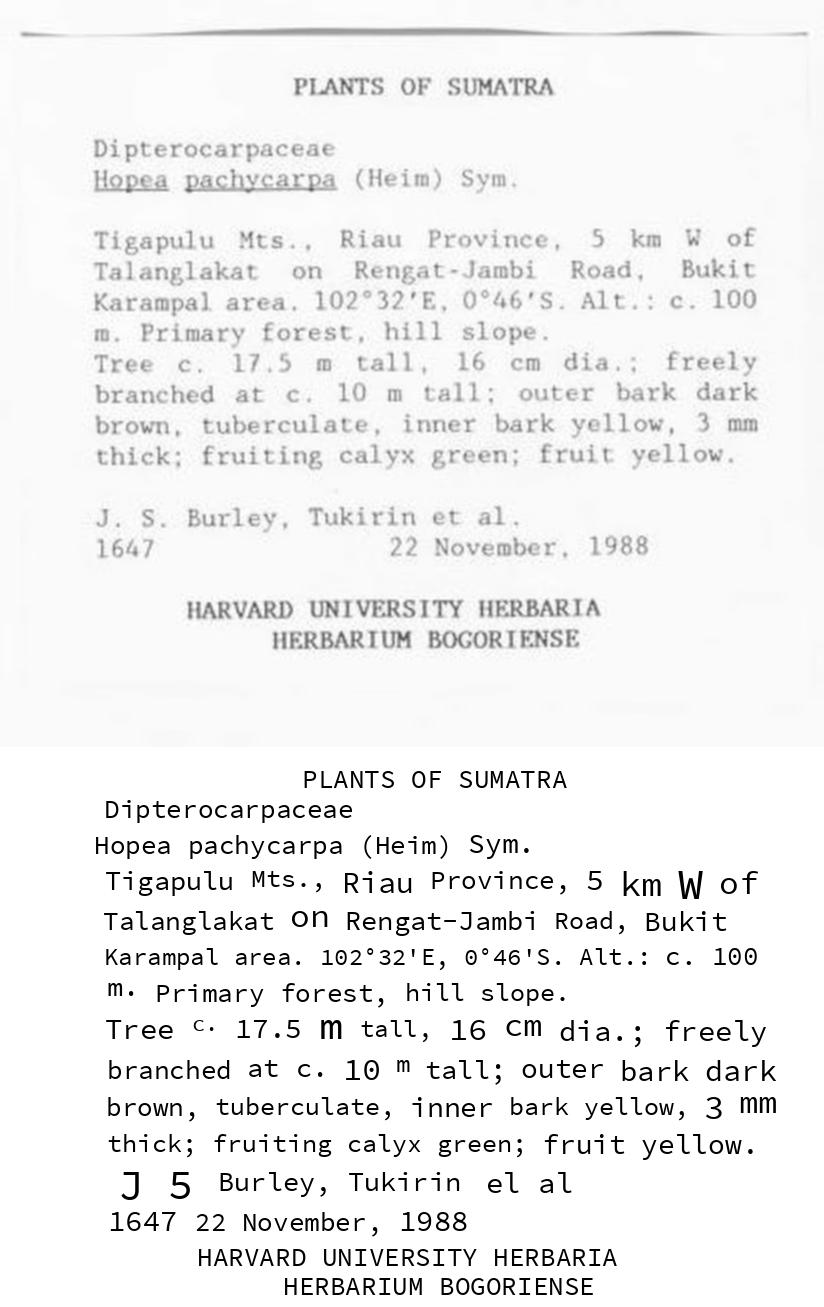

In [58]:
image = Image.open(images[42])
display(image)

This still looks like a ransom note. I should choose one font size per line and use that consistently.